# Adaptive Clustering based Intrusion Detection


## Imports

In [7]:
#!/usr/bin/env python

__author__ = "Alec F."
__license__ = "GPL"
__version__ = "1.0.1"


import os
import sys
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from core.models.network import AdaptiveClustering
from core.utils.misc import extend_dataset
from core.utils import Dataset

import json

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from core.models.RandomForest import RandomForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as prf, accuracy_score

from pprint import pprint

from codecarbon import track_emissions
from datetime import datetime
import time


## Helpers

We use these helpers functions throughout all our experiments for simplify our main code and improve its readability. In all our experiments, our datasets are separated to approximately obtain a 70/30 train-test split from randomly sampled data. We use the pickle library to save our trained model and defined a set of metrics that are commonly used for classification tasks.

In [27]:
def load_dataset(dataset_path):
    global categories
    if not os.path.exists(dataset_path):
        print(f"Dataset not found: {dataset_path}")
        sys.exit(1)

    df = pd.read_csv(dataset_path, index_col=False, sep=",")

    
    # For binary classification, uncomment the following line
    df['Label.'] = np.where(df['Label.'] == 0, "Normal", "Attack")

    
    train_test_split = .3
    msk = np.random.rand(len(df)) < train_test_split
    train_df = df[msk]
    test_df = df[~msk]

    return train_df, test_df, df


def save_model(rf, filename):
    with open(filename, 'wb') as f:
        pkl.dump(rf, f)


def load_model(filename):
    with open(filename, 'rb') as f:
        m = pkl.load(f)
    return m


class metrics(object):

    def __init__(self, tp=None, tn=None, fp=None, fn=None):
        super(metrics, self).__init__()

        self.tp, self.tn, self.fp, self.fn = tp, tn, fp, fn

        self.metrics = {}

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def detection_rate(self):
        return self.tp / (self.tp + self.fn)

    def false_alarm_rate(self):
        return self.fp / (self.fp + self.tn)

    def precision(self):
        return self.tp / (self.tp + self.fp)

    def f1(self):
        prec = self.precision()
        rec = self.detection_rate()
        return 0 if (prec + rec) == 0 else 2 * (prec * rec) / (prec + rec)

    def get_metrics(self):
        self.metrics = {"Acc": self.accuracy(), "DR/Recall": self.detection_rate(), "FAR": self.false_alarm_rate(),
                        "PRECISION": self.precision(), "F1 SCORE": self.f1()}
        return self.metrics

## Adaptive Clustering - training function

We train our Adaptive Clustering network by following the exact settings provided in the paper.
However, we also implement an early stop mechanism allowing us to stop the training as soon as we achieve an acceptable loss.

In [28]:
@track_emissions(tracking_mode='process')
def train(X, y,j,dic_loss, lr=1e-4):

    dic_loss[f"entrainement_{j}"] = {}

    batch_size = 1024
    print("Adaptive training...")
    model_ = AdaptiveClustering(encoder_dims=[500, 100, 50], n_kernels=len(categories), kernel_size=10)
    model_.train()


    ds = Dataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=8)

    n_epoch = 4
    optimizer = None

    for i in range(n_epoch):
        iteration_losses = []
        
        for x, labels_ in dl:
            model_.zero_grad()
            _ = model_(x, labels_)
            if optimizer is None:
                optimizer = torch.optim.Adam(model_.parameters(), lr=lr)

            loss = model_.loss()
            loss_value = loss.item()

            iteration_losses.append(loss_value)

            loss.backward()
            optimizer.step()
        dic_loss[f"entrainement_{j}"][f"epoch_{i}"] = iteration_losses
        print(f"Iteration {i} | Loss {np.mean(iteration_losses)}")

    model_.eval()
    return model_

## Variables

Here we define some global variables to locate our datasets and point to our results directory.

In [8]:
root_path = './'

dataset_path = root_path + 'datasets/KDD/kddcup_corrige.csv'


results_path = root_path + f'results_100/'
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [9]:
model_path = results_path + 'trained_model.pkl'
separator = "-"*50

## Dataset
### Loading dataset

We load the preprocessed dataset as a pandas data frame and show the first few rows.

In [31]:
print(separator)
print("Loading dataset...")

train_df, test_df, df = load_dataset(dataset_path)
print("Done loading dataset")


--------------------------------------------------
Loading dataset...
Done loading dataset


In [32]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label.
0,0,0,0,0,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,Attack
1,0,0,0,0,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,Normal
2,0,0,0,0,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,Normal
3,0,0,0,0,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,Normal
4,0,0,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,Normal


### Preparing the data

We prepare the features to be in the correct format for our Adaptive Clustering network and the Random Forest Classifier.

The labels are separated from the training features and the order of the categories are kept track of in order to use them in the same order when evaluating the model on the testing set.

In [33]:
if os.path.exists(model_path + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path}.categories")
    print("Done loading categories")
else:
    print("Creating categories...")
    categories = list(set(pd.factorize(train_df['Label.'])[1].values))
    print("Done creating categories...")

print("catégories de trafic traitées:",categories)

train_df_ = train_df.drop(['Label.'], axis=1)

X = train_df_.values.tolist()
y = train_df['Label.'].values.tolist()

X = torch.FloatTensor(np.array(X))

for i, l in enumerate(y):
    y[i] = categories.index(l)

y = torch.LongTensor(np.array(y))

cats = df['Label.'].copy()
y_ = df['Label.'].values
df.drop(['Label.'], axis=1, inplace=True)

Creating categories...
Done creating categories...
catégories de trafic traitées: ['Attack', 'Normal']


## Learning

### Training the model

We train our model until we achieve an acceptable loss and export an extended dataset with the cluster centers obtained from the Adaptive Clustering network. This would allow us to not have to retrain our network for every single execution.

In [34]:
dico_temps = {}
if not os.path.exists(model_path):
    global dic_loss
    dic_loss = {}
    print("Training model...")

    debut = time.time()
    date = datetime.now()
    model = train(X, y, 0,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_0"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_1 = train(X, y, 1,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_1"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_2 = train(X, y, 2,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_2"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_3 = train(X, y, 3,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_3"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_4 = train(X, y, 4,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_4"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_5 = train(X, y, 5,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_5"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_6 = train(X, y, 6,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_6"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_7 = train(X, y, 7,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_7"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_8 = train(X, y, 8,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_8"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_9 = train(X, y, 9,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_9"] = [date,durée]

    # Sauvegarde du dictionnaire_loss dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dic_loss.pkl", 'wb') as file:
        pkl.dump(dic_loss, file)

    # Sauvegarde du dictionnaire_temps dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dico_temps.pkl", 'wb') as file:
        pkl.dump(dico_temps, file)

    print("Done training model")


[codecarbon WARNING @ 12:38:02] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 12:38:02] [setup] RAM Tracking...
[codecarbon INFO @ 12:38:02] [setup] GPU Tracking...


Training model...


[codecarbon INFO @ 12:38:03] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:38:03] [setup] CPU Tracking...
[codecarbon WARNING @ 12:38:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:38:05] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 12:38:05] >>> Tracker's metadata:
[codecarbon INFO @ 12:38:05]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 12:38:05]   Python version: 3.11.9
[codecarbon INFO @ 12:38:05]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 12:38:05]   Available RAM : 15.422 GB
[codecarbon INFO @ 12:38:05]   CPU count: 16
[codecarbon INFO @ 12:38:05]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 12:38:05]   GPU count: 1
[codecarbon INFO @ 12:38:05]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 12:38:23] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:38:25] Energy consumed for all GPUs : 0.000034 kWh. Total GPU Power : 8.238701233244933 W
[codecarbon INFO @ 12:38:25] Energy consumed for all CPUs : 0.000101 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:38:25] 0.000159 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:38] Energy consumed for RAM : 0.000046 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:38:39] Energy consumed for all GPUs : 0.000105 kWh. Total GPU Power : 18.425118256581325 W
[codecarbon INFO @ 12:38:39] Energy consumed for all CPUs : 0.000191 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:38:39] 0.000342 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:54] Energy consumed for RAM : 0.000070 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:38:54] Energy consumed for all GPUs : 0.000173 kWh. Total GPU Power : 16.8392669020240

Iteration 0 | Loss 21.81840983213089


[codecarbon INFO @ 12:42:09] Energy consumed for RAM : 0.000373 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:42:09] Energy consumed for all GPUs : 0.001104 kWh. Total GPU Power : 17.92469763183577 W
[codecarbon INFO @ 12:42:09] Energy consumed for all CPUs : 0.001504 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:42:09] 0.002980 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:24] Energy consumed for RAM : 0.000396 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:42:24] Energy consumed for all GPUs : 0.001177 kWh. Total GPU Power : 18.109983883257026 W
[codecarbon INFO @ 12:42:24] Energy consumed for all CPUs : 0.001598 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:42:24] 0.003171 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:39] Energy consumed for RAM : 0.000419 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:42:39] Energy consumed for all GPUs : 0.001249 kWh. Total GPU Power : 17.9090744889195

Iteration 1 | Loss 0.01422133720557732


[codecarbon INFO @ 12:45:54] Energy consumed for RAM : 0.000722 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:45:54] Energy consumed for all GPUs : 0.002183 kWh. Total GPU Power : 17.555072298928774 W
[codecarbon INFO @ 12:45:54] Energy consumed for all CPUs : 0.002911 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:45:54] 0.005815 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:09] Energy consumed for RAM : 0.000745 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:46:09] Energy consumed for all GPUs : 0.002253 kWh. Total GPU Power : 17.545522109329724 W
[codecarbon INFO @ 12:46:09] Energy consumed for all CPUs : 0.003005 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:46:09] 0.006003 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:24] Energy consumed for RAM : 0.000768 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:46:24] Energy consumed for all GPUs : 0.002324 kWh. Total GPU Power : 17.606025655572

Iteration 2 | Loss 0.008880279593436893


[codecarbon INFO @ 12:49:24] Energy consumed for RAM : 0.001048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:49:24] Energy consumed for all GPUs : 0.003178 kWh. Total GPU Power : 17.551295968659637 W
[codecarbon INFO @ 12:49:24] Energy consumed for all CPUs : 0.004224 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:49:24] 0.008450 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:39] Energy consumed for RAM : 0.001071 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:49:39] Energy consumed for all GPUs : 0.003249 kWh. Total GPU Power : 17.521138818811668 W
[codecarbon INFO @ 12:49:39] Energy consumed for all CPUs : 0.004318 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:49:39] 0.008638 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:54] Energy consumed for RAM : 0.001094 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:49:54] Energy consumed for all GPUs : 0.003321 kWh. Total GPU Power : 17.880085798853

Iteration 3 | Loss 0.005173794350716218


[codecarbon INFO @ 12:52:41] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 12:52:41] >>> Tracker's metadata:
[codecarbon INFO @ 12:52:41]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 12:52:41]   Python version: 3.11.9
[codecarbon INFO @ 12:52:41]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 12:52:41]   Available RAM : 15.422 GB
[codecarbon INFO @ 12:52:41]   CPU count: 16
[codecarbon INFO @ 12:52:41]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 12:52:41]   GPU count: 1
[codecarbon INFO @ 12:52:41]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 12:52:59] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:53:01] Energy consumed for all GPUs : 0.000037 kWh. Total GPU Power : 8.790420646703637 W
[codecarbon INFO @ 12:53:01] Energy consumed for all CPUs : 0.000101 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:53:01] 0.000162 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:14] Energy consumed for RAM : 0.000046 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:53:15] Energy consumed for all GPUs : 0.000114 kWh. Total GPU Power : 20.1347169870822 W
[codecarbon INFO @ 12:53:15] Energy consumed for all CPUs : 0.000191 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:53:15] 0.000351 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:29] Energy consumed for RAM : 0.000070 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:53:30] Energy consumed for all GPUs : 0.000186 kWh. Total GPU Power : 17.89737989889887 

Iteration 0 | Loss 0.5773969173540353


[codecarbon INFO @ 12:56:30] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:56:30] Energy consumed for all GPUs : 0.001042 kWh. Total GPU Power : 17.663670720024058 W
[codecarbon INFO @ 12:56:30] Energy consumed for all CPUs : 0.001410 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:56:30] 0.002801 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:45] Energy consumed for RAM : 0.000373 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:56:45] Energy consumed for all GPUs : 0.001114 kWh. Total GPU Power : 17.85073140377096 W
[codecarbon INFO @ 12:56:45] Energy consumed for all CPUs : 0.001504 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 12:56:45] 0.002990 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:57:00] Energy consumed for RAM : 0.000396 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 12:57:00] Energy consumed for all GPUs : 0.001185 kWh. Total GPU Power : 17.5886236880864

Iteration 1 | Loss 0.03465610708260499


[codecarbon INFO @ 13:00:00] Energy consumed for RAM : 0.000675 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:00:00] Energy consumed for all GPUs : 0.002039 kWh. Total GPU Power : 17.67599574135327 W
[codecarbon INFO @ 13:00:00] Energy consumed for all CPUs : 0.002723 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:00:00] 0.005438 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:15] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:00:15] Energy consumed for all GPUs : 0.002110 kWh. Total GPU Power : 17.607111145474313 W
[codecarbon INFO @ 13:00:15] Energy consumed for all CPUs : 0.002817 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:00:15] 0.005626 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:30] Energy consumed for RAM : 0.000722 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:00:30] Energy consumed for all GPUs : 0.002182 kWh. Total GPU Power : 17.7112550194675

Iteration 2 | Loss 0.01787081300614993


[codecarbon INFO @ 13:03:15] Energy consumed for all GPUs : 0.002964 kWh. Total GPU Power : 17.56000680304917 W
[codecarbon INFO @ 13:03:15] Energy consumed for all CPUs : 0.003942 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:03:15] 0.007885 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:30] Energy consumed for RAM : 0.001002 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:03:30] Energy consumed for all GPUs : 0.003035 kWh. Total GPU Power : 17.620648220755818 W
[codecarbon INFO @ 13:03:30] Energy consumed for all CPUs : 0.004036 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:03:30] 0.008073 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:45] Energy consumed for RAM : 0.001025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:03:45] Energy consumed for all GPUs : 0.003106 kWh. Total GPU Power : 17.60013660262112 W
[codecarbon INFO @ 13:03:45] Energy consumed for all CPUs : 0.004130 kWh. Total CPU Power : 22.5 

Iteration 3 | Loss 0.011673823367540977


[codecarbon INFO @ 13:06:53] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:06:53] >>> Tracker's metadata:
[codecarbon INFO @ 13:06:53]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 13:06:53]   Python version: 3.11.9
[codecarbon INFO @ 13:06:53]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 13:06:53]   Available RAM : 15.422 GB
[codecarbon INFO @ 13:06:53]   CPU count: 16
[codecarbon INFO @ 13:06:53]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:06:53]   GPU count: 1
[codecarbon INFO @ 13:06:53]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 13:07:12] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:07:12] Energy consumed for all GPUs : 0.000072 kWh. Total GPU Power : 16.63785985281074 W
[codecarbon INFO @ 13:07:12] Energy consumed for all CPUs : 0.000100 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:07:12] 0.000197 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:07:27] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:07:27] Energy consumed for all GPUs : 0.000143 kWh. Total GPU Power : 17.705986765173545 W
[codecarbon INFO @ 13:07:27] Energy consumed for all CPUs : 0.000194 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:07:27] 0.000385 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:07:42] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:07:42] Energy consumed for all GPUs : 0.000214 kWh. Total GPU Power : 17.5297242922099

Iteration 0 | Loss 0.35659602239681276


[codecarbon INFO @ 13:10:42] Energy consumed for RAM : 0.000351 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:10:42] Energy consumed for all GPUs : 0.001073 kWh. Total GPU Power : 17.537967127205448 W
[codecarbon INFO @ 13:10:42] Energy consumed for all CPUs : 0.001413 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:10:42] 0.002837 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:10:57] Energy consumed for RAM : 0.000374 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:10:57] Energy consumed for all GPUs : 0.001144 kWh. Total GPU Power : 17.690247737578556 W
[codecarbon INFO @ 13:10:57] Energy consumed for all CPUs : 0.001507 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:10:57] 0.003025 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:12] Energy consumed for RAM : 0.000398 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:11:12] Energy consumed for all GPUs : 0.001214 kWh. Total GPU Power : 17.503757322412

Iteration 1 | Loss 0.01845514209335281


[codecarbon INFO @ 13:13:57] Energy consumed for all GPUs : 0.001995 kWh. Total GPU Power : 17.872445300623134 W
[codecarbon INFO @ 13:13:57] Energy consumed for all CPUs : 0.002632 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:13:57] 0.005281 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:12] Energy consumed for RAM : 0.000677 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:14:12] Energy consumed for all GPUs : 0.002066 kWh. Total GPU Power : 17.751394498008903 W
[codecarbon INFO @ 13:14:12] Energy consumed for all CPUs : 0.002726 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:14:12] 0.005470 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:27] Energy consumed for RAM : 0.000700 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:14:27] Energy consumed for all GPUs : 0.002137 kWh. Total GPU Power : 17.624188148677735 W
[codecarbon INFO @ 13:14:27] Energy consumed for all CPUs : 0.002820 kWh. Total CPU Power : 22.

Iteration 2 | Loss 0.011236807879308254


[codecarbon INFO @ 13:17:27] Energy consumed for RAM : 0.000980 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:17:27] Energy consumed for all GPUs : 0.002992 kWh. Total GPU Power : 17.541324761541368 W
[codecarbon INFO @ 13:17:27] Energy consumed for all CPUs : 0.003945 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:17:27] 0.007918 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:17:42] Energy consumed for RAM : 0.001003 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:17:42] Energy consumed for all GPUs : 0.003063 kWh. Total GPU Power : 17.67094551557105 W
[codecarbon INFO @ 13:17:42] Energy consumed for all CPUs : 0.004039 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:17:42] 0.008106 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:17:57] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:17:57] Energy consumed for all GPUs : 0.003134 kWh. Total GPU Power : 17.6103225884796

Iteration 3 | Loss 0.008963379692563509


[codecarbon INFO @ 13:21:00] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:21:00] >>> Tracker's metadata:
[codecarbon INFO @ 13:21:00]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 13:21:00]   Python version: 3.11.9
[codecarbon INFO @ 13:21:00]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 13:21:00]   Available RAM : 15.422 GB
[codecarbon INFO @ 13:21:00]   CPU count: 16
[codecarbon INFO @ 13:21:00]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:21:00]   GPU count: 1
[codecarbon INFO @ 13:21:00]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 13:21:18] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:21:20] Energy consumed for all GPUs : 0.000031 kWh. Total GPU Power : 7.438253529753323 W
[codecarbon INFO @ 13:21:20] Energy consumed for all CPUs : 0.000101 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:21:20] 0.000156 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:21:33] Energy consumed for RAM : 0.000046 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:21:34] Energy consumed for all GPUs : 0.000108 kWh. Total GPU Power : 19.86932357457571 W
[codecarbon INFO @ 13:21:34] Energy consumed for all CPUs : 0.000191 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:21:34] 0.000345 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:21:48] Energy consumed for RAM : 0.000070 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:21:49] Energy consumed for all GPUs : 0.000182 kWh. Total GPU Power : 18.33980274199881

Iteration 0 | Loss 0.6176553779180501


[codecarbon INFO @ 13:24:49] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:24:49] Energy consumed for all GPUs : 0.001040 kWh. Total GPU Power : 17.785542645243837 W
[codecarbon INFO @ 13:24:49] Energy consumed for all CPUs : 0.001410 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:24:49] 0.002799 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:04] Energy consumed for RAM : 0.000373 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:25:04] Energy consumed for all GPUs : 0.001112 kWh. Total GPU Power : 17.967656999492934 W
[codecarbon INFO @ 13:25:04] Energy consumed for all CPUs : 0.001504 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:25:04] 0.002988 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:19] Energy consumed for RAM : 0.000396 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:25:19] Energy consumed for all GPUs : 0.001184 kWh. Total GPU Power : 17.795403437332

Iteration 1 | Loss 0.039556341280792336


[codecarbon INFO @ 13:28:19] Energy consumed for RAM : 0.000675 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:28:19] Energy consumed for all GPUs : 0.002039 kWh. Total GPU Power : 17.7415872648418 W
[codecarbon INFO @ 13:28:19] Energy consumed for all CPUs : 0.002723 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:28:19] 0.005437 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:28:34] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:28:34] Energy consumed for all GPUs : 0.002110 kWh. Total GPU Power : 17.71516591018977 W
[codecarbon INFO @ 13:28:34] Energy consumed for all CPUs : 0.002817 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:28:34] 0.005626 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:28:49] Energy consumed for RAM : 0.000722 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:28:49] Energy consumed for all GPUs : 0.002181 kWh. Total GPU Power : 17.600969237608485

Iteration 2 | Loss 0.017685575500224045


[codecarbon INFO @ 13:31:49] Energy consumed for RAM : 0.001001 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:31:49] Energy consumed for all GPUs : 0.003035 kWh. Total GPU Power : 17.621594011736235 W
[codecarbon INFO @ 13:31:49] Energy consumed for all CPUs : 0.004036 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:31:49] 0.008072 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:32:04] Energy consumed for RAM : 0.001025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:32:04] Energy consumed for all GPUs : 0.003107 kWh. Total GPU Power : 17.876099068011445 W
[codecarbon INFO @ 13:32:04] Energy consumed for all CPUs : 0.004130 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:32:04] 0.008261 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:32:19] Energy consumed for RAM : 0.001048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:32:19] Energy consumed for all GPUs : 0.003178 kWh. Total GPU Power : 17.660008112374

Iteration 3 | Loss 0.013248055812728936


[codecarbon INFO @ 13:35:11] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:35:11] >>> Tracker's metadata:
[codecarbon INFO @ 13:35:11]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 13:35:11]   Python version: 3.11.9
[codecarbon INFO @ 13:35:11]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 13:35:11]   Available RAM : 15.422 GB
[codecarbon INFO @ 13:35:11]   CPU count: 16
[codecarbon INFO @ 13:35:11]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:35:11]   GPU count: 1
[codecarbon INFO @ 13:35:11]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 13:35:30] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:35:31] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 16.254477813866508 W
[codecarbon INFO @ 13:35:31] Energy consumed for all CPUs : 0.000101 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:35:31] 0.000197 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:35:45] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:35:46] Energy consumed for all GPUs : 0.000142 kWh. Total GPU Power : 17.747105525324997 W
[codecarbon INFO @ 13:35:46] Energy consumed for all CPUs : 0.000195 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:35:46] 0.000385 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:36:00] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:36:01] Energy consumed for all GPUs : 0.000214 kWh. Total GPU Power : 17.778947357664

Iteration 0 | Loss 0.524736434820531


[codecarbon INFO @ 13:39:00] Energy consumed for RAM : 0.000351 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:39:01] Energy consumed for all GPUs : 0.001071 kWh. Total GPU Power : 17.65748288249888 W
[codecarbon INFO @ 13:39:01] Energy consumed for all CPUs : 0.001414 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:39:01] 0.002836 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:15] Energy consumed for RAM : 0.000374 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:39:16] Energy consumed for all GPUs : 0.001142 kWh. Total GPU Power : 17.671861103366492 W
[codecarbon INFO @ 13:39:16] Energy consumed for all CPUs : 0.001507 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:39:16] 0.003024 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:30] Energy consumed for RAM : 0.000398 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:39:31] Energy consumed for all GPUs : 0.001213 kWh. Total GPU Power : 17.6552446313998

Iteration 1 | Loss 0.01820461576529532


[codecarbon INFO @ 13:42:31] Energy consumed for RAM : 0.000677 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:42:31] Energy consumed for all GPUs : 0.002071 kWh. Total GPU Power : 17.88312656018146 W
[codecarbon INFO @ 13:42:31] Energy consumed for all CPUs : 0.002727 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:42:31] 0.005475 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:42:46] Energy consumed for RAM : 0.000701 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:42:46] Energy consumed for all GPUs : 0.002141 kWh. Total GPU Power : 17.52463993778931 W
[codecarbon INFO @ 13:42:46] Energy consumed for all CPUs : 0.002821 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:42:46] 0.005663 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:01] Energy consumed for RAM : 0.000724 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:43:01] Energy consumed for all GPUs : 0.002212 kWh. Total GPU Power : 17.63753235529961

Iteration 2 | Loss 0.013388832026043865


[codecarbon INFO @ 13:46:01] Energy consumed for RAM : 0.001003 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:46:01] Energy consumed for all GPUs : 0.003066 kWh. Total GPU Power : 17.61904489935843 W
[codecarbon INFO @ 13:46:01] Energy consumed for all CPUs : 0.004040 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:46:01] 0.008109 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:16] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:46:16] Energy consumed for all GPUs : 0.003137 kWh. Total GPU Power : 17.533478913862194 W
[codecarbon INFO @ 13:46:16] Energy consumed for all CPUs : 0.004134 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:46:16] 0.008297 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:31] Energy consumed for RAM : 0.001050 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:46:31] Energy consumed for all GPUs : 0.003207 kWh. Total GPU Power : 17.5855349789672

Iteration 3 | Loss 0.009607862775271737


[codecarbon INFO @ 13:49:24] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:49:24] >>> Tracker's metadata:
[codecarbon INFO @ 13:49:24]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 13:49:24]   Python version: 3.11.9
[codecarbon INFO @ 13:49:24]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 13:49:24]   Available RAM : 15.422 GB
[codecarbon INFO @ 13:49:24]   CPU count: 16
[codecarbon INFO @ 13:49:24]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 13:49:24]   GPU count: 1
[codecarbon INFO @ 13:49:24]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 13:49:43] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:49:43] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 16.569374458670634 W
[codecarbon INFO @ 13:49:43] Energy consumed for all CPUs : 0.000100 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:49:43] 0.000197 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:49:58] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:49:58] Energy consumed for all GPUs : 0.000143 kWh. Total GPU Power : 17.698427420446233 W
[codecarbon INFO @ 13:49:58] Energy consumed for all CPUs : 0.000194 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:49:58] 0.000385 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:50:13] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:50:13] Energy consumed for all GPUs : 0.000215 kWh. Total GPU Power : 17.845029717452

Iteration 0 | Loss 13.243858540754943


[codecarbon INFO @ 13:52:58] Energy consumed for RAM : 0.000328 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:52:58] Energy consumed for all GPUs : 0.000997 kWh. Total GPU Power : 17.521956305948 W
[codecarbon INFO @ 13:52:58] Energy consumed for all CPUs : 0.001320 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:52:58] 0.002644 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:53:13] Energy consumed for RAM : 0.000351 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:53:13] Energy consumed for all GPUs : 0.001068 kWh. Total GPU Power : 17.683576598897663 W
[codecarbon INFO @ 13:53:13] Energy consumed for all CPUs : 0.001413 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:53:13] 0.002832 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:53:28] Energy consumed for RAM : 0.000374 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:53:28] Energy consumed for all GPUs : 0.001139 kWh. Total GPU Power : 17.734688018616286

Iteration 1 | Loss 0.024120758580754725


[codecarbon INFO @ 13:56:28] Energy consumed for all GPUs : 0.001991 kWh. Total GPU Power : 17.58893335795949 W
[codecarbon INFO @ 13:56:28] Energy consumed for all CPUs : 0.002632 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:56:28] 0.005277 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:43] Energy consumed for RAM : 0.000677 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:56:43] Energy consumed for all GPUs : 0.002062 kWh. Total GPU Power : 17.68023445207929 W
[codecarbon INFO @ 13:56:43] Energy consumed for all CPUs : 0.002726 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 13:56:43] 0.005465 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:58] Energy consumed for RAM : 0.000700 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 13:56:58] Energy consumed for all GPUs : 0.002133 kWh. Total GPU Power : 17.600273282982535 W
[codecarbon INFO @ 13:56:58] Energy consumed for all CPUs : 0.002820 kWh. Total CPU Power : 22.5 

Iteration 2 | Loss 0.013585491264161127


[codecarbon INFO @ 14:00:13] Energy consumed for RAM : 0.001003 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:00:13] Energy consumed for all GPUs : 0.003057 kWh. Total GPU Power : 17.604079633084147 W
[codecarbon INFO @ 14:00:13] Energy consumed for all CPUs : 0.004039 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:00:13] 0.008099 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:00:28] Energy consumed for RAM : 0.001026 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:00:28] Energy consumed for all GPUs : 0.003128 kWh. Total GPU Power : 17.647556414108976 W
[codecarbon INFO @ 14:00:28] Energy consumed for all CPUs : 0.004133 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:00:28] 0.008288 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:00:43] Energy consumed for RAM : 0.001050 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:00:43] Energy consumed for all GPUs : 0.003199 kWh. Total GPU Power : 17.629738912118

Iteration 3 | Loss 0.009838453340305219


[codecarbon INFO @ 14:03:31] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 14:03:31] >>> Tracker's metadata:
[codecarbon INFO @ 14:03:31]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 14:03:31]   Python version: 3.11.9
[codecarbon INFO @ 14:03:31]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 14:03:31]   Available RAM : 15.422 GB
[codecarbon INFO @ 14:03:31]   CPU count: 16
[codecarbon INFO @ 14:03:31]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 14:03:31]   GPU count: 1
[codecarbon INFO @ 14:03:31]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 14:03:50] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:03:51] Energy consumed for all GPUs : 0.000028 kWh. Total GPU Power : 6.648036423855443 W
[codecarbon INFO @ 14:03:51] Energy consumed for all CPUs : 0.000101 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:03:51] 0.000153 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:05] Energy consumed for RAM : 0.000046 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:04:05] Energy consumed for all GPUs : 0.000103 kWh. Total GPU Power : 19.455513472831807 W
[codecarbon INFO @ 14:04:05] Energy consumed for all CPUs : 0.000191 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:04:05] 0.000340 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:20] Energy consumed for RAM : 0.000070 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:04:20] Energy consumed for all GPUs : 0.000177 kWh. Total GPU Power : 18.3799975174067

Iteration 0 | Loss 0.7776890752582829


[codecarbon INFO @ 14:07:05] Energy consumed for RAM : 0.000326 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:07:05] Energy consumed for all GPUs : 0.000957 kWh. Total GPU Power : 17.810965852706698 W
[codecarbon INFO @ 14:07:05] Energy consumed for all CPUs : 0.001316 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:07:05] 0.002599 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:07:20] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:07:20] Energy consumed for all GPUs : 0.001028 kWh. Total GPU Power : 17.61510541360999 W
[codecarbon INFO @ 14:07:20] Energy consumed for all CPUs : 0.001410 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:07:20] 0.002787 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:07:35] Energy consumed for RAM : 0.000372 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:07:35] Energy consumed for all GPUs : 0.001099 kWh. Total GPU Power : 17.7269801785787

Iteration 1 | Loss 0.06177517053383223


[codecarbon INFO @ 14:10:35] Energy consumed for RAM : 0.000652 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:10:35] Energy consumed for all GPUs : 0.001955 kWh. Total GPU Power : 18.03364161175165 W
[codecarbon INFO @ 14:10:35] Energy consumed for all CPUs : 0.002629 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:10:35] 0.005236 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:10:50] Energy consumed for RAM : 0.000675 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:10:50] Energy consumed for all GPUs : 0.002026 kWh. Total GPU Power : 17.764928236255233 W
[codecarbon INFO @ 14:10:50] Energy consumed for all CPUs : 0.002723 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:10:50] 0.005425 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:11:05] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:11:06] Energy consumed for all GPUs : 0.002097 kWh. Total GPU Power : 17.5690231547497

Iteration 2 | Loss 0.022547858429963707


[codecarbon INFO @ 14:14:05] Energy consumed for RAM : 0.000978 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:14:06] Energy consumed for all GPUs : 0.002951 kWh. Total GPU Power : 17.583466691021158 W
[codecarbon INFO @ 14:14:06] Energy consumed for all CPUs : 0.003942 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:14:06] 0.007872 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:14:20] Energy consumed for RAM : 0.001001 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:14:21] Energy consumed for all GPUs : 0.003022 kWh. Total GPU Power : 17.597121155114117 W
[codecarbon INFO @ 14:14:21] Energy consumed for all CPUs : 0.004036 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:14:21] 0.008060 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:14:35] Energy consumed for RAM : 0.001025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:14:36] Energy consumed for all GPUs : 0.003093 kWh. Total GPU Power : 17.625403435293

Iteration 3 | Loss 0.014638640749375894


[codecarbon INFO @ 14:17:36] Energy consumed for all GPUs : 0.003948 kWh. Total GPU Power : 17.559384733570614 W
[codecarbon INFO @ 14:17:36] Energy consumed for all CPUs : 0.005255 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:17:36] Energy consumed for all GPUs : 0.003948 kWh. Total GPU Power : 0.0 W
[codecarbon INFO @ 14:17:36] 0.010531 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:17:36] Energy consumed for all CPUs : 0.005349 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:17:36] 0.010625 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:17:36] Done!

[codecarbon WARNING @ 14:17:36] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 14:17:36] [setup] RAM Tracking...
[codecarbon INFO @ 14:17:36] [setup] GPU Tracking...
[codecarbon INFO @ 14:17:36] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:17:36] [setup] CPU Tracking...
[codecarbon WARNING @ 14:17:36] No CPU tracking mode found. Falling back on C

Adaptive training...


[codecarbon INFO @ 14:17:56] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:17:57] Energy consumed for all GPUs : 0.000038 kWh. Total GPU Power : 9.051096396654733 W
[codecarbon INFO @ 14:17:57] Energy consumed for all CPUs : 0.000101 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:17:57] 0.000163 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:18:11] Energy consumed for RAM : 0.000046 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:18:11] Energy consumed for all GPUs : 0.000114 kWh. Total GPU Power : 19.658035120026458 W
[codecarbon INFO @ 14:18:11] Energy consumed for all CPUs : 0.000191 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:18:11] 0.000351 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:18:26] Energy consumed for RAM : 0.000070 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:18:26] Energy consumed for all GPUs : 0.000187 kWh. Total GPU Power : 18.1505258286736

Iteration 0 | Loss 0.31279627205596455


[codecarbon INFO @ 14:21:26] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:21:26] Energy consumed for all GPUs : 0.001047 kWh. Total GPU Power : 17.861886016407905 W
[codecarbon INFO @ 14:21:26] Energy consumed for all CPUs : 0.001410 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:21:26] 0.002806 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:21:41] Energy consumed for RAM : 0.000373 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:21:41] Energy consumed for all GPUs : 0.001119 kWh. Total GPU Power : 17.809694559313225 W
[codecarbon INFO @ 14:21:41] Energy consumed for all CPUs : 0.001504 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:21:41] 0.002995 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:21:56] Energy consumed for RAM : 0.000396 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:21:56] Energy consumed for all GPUs : 0.001191 kWh. Total GPU Power : 17.871985411223

Iteration 1 | Loss 0.02548827774580153


[codecarbon INFO @ 14:24:56] Energy consumed for RAM : 0.000675 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:24:56] Energy consumed for all GPUs : 0.002047 kWh. Total GPU Power : 17.7132752844924 W
[codecarbon INFO @ 14:24:56] Energy consumed for all CPUs : 0.002723 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:24:56] 0.005446 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:11] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:25:11] Energy consumed for all GPUs : 0.002119 kWh. Total GPU Power : 17.73344052729943 W
[codecarbon INFO @ 14:25:11] Energy consumed for all CPUs : 0.002817 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:25:11] 0.005634 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:26] Energy consumed for RAM : 0.000722 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:25:26] Energy consumed for all GPUs : 0.002191 kWh. Total GPU Power : 17.76581162970462 

Iteration 2 | Loss 0.012874741844144133


[codecarbon INFO @ 14:28:26] Energy consumed for RAM : 0.001001 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:28:26] Energy consumed for all GPUs : 0.003046 kWh. Total GPU Power : 17.7093538813727 W
[codecarbon INFO @ 14:28:26] Energy consumed for all CPUs : 0.004036 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:28:26] 0.008083 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:41] Energy consumed for RAM : 0.001025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:28:41] Energy consumed for all GPUs : 0.003117 kWh. Total GPU Power : 17.737919737872197 W
[codecarbon INFO @ 14:28:41] Energy consumed for all CPUs : 0.004130 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:28:41] 0.008271 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:56] Energy consumed for RAM : 0.001048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:28:56] Energy consumed for all GPUs : 0.003188 kWh. Total GPU Power : 17.69723746818599

Iteration 3 | Loss 0.008155576628730126


[codecarbon INFO @ 14:31:51] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 14:31:51] >>> Tracker's metadata:
[codecarbon INFO @ 14:31:51]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 14:31:51]   Python version: 3.11.9
[codecarbon INFO @ 14:31:51]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 14:31:51]   Available RAM : 15.422 GB
[codecarbon INFO @ 14:31:51]   CPU count: 16
[codecarbon INFO @ 14:31:51]   CPU model: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon INFO @ 14:31:51]   GPU count: 1
[codecarbon INFO @ 14:31:51]   GPU model: 1 x NVIDIA GeForce RTX 3060 Laptop GPU


Adaptive training...


[codecarbon INFO @ 14:32:10] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:32:11] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 16.525682069681988 W
[codecarbon INFO @ 14:32:11] Energy consumed for all CPUs : 0.000100 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:32:11] 0.000196 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:32:25] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:32:26] Energy consumed for all GPUs : 0.000142 kWh. Total GPU Power : 17.676263034372738 W
[codecarbon INFO @ 14:32:26] Energy consumed for all CPUs : 0.000194 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:32:26] 0.000385 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:32:40] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:32:41] Energy consumed for all GPUs : 0.000214 kWh. Total GPU Power : 17.718893370702

Iteration 0 | Loss 0.4392830848909167


[codecarbon INFO @ 14:35:40] Energy consumed for RAM : 0.000351 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:35:41] Energy consumed for all GPUs : 0.001071 kWh. Total GPU Power : 17.804981610888028 W
[codecarbon INFO @ 14:35:41] Energy consumed for all CPUs : 0.001413 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:35:41] 0.002835 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:35:55] Energy consumed for RAM : 0.000374 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:35:56] Energy consumed for all GPUs : 0.001142 kWh. Total GPU Power : 17.766268706676932 W
[codecarbon INFO @ 14:35:56] Energy consumed for all CPUs : 0.001507 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:35:56] 0.003023 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:10] Energy consumed for RAM : 0.000398 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:36:11] Energy consumed for all GPUs : 0.001214 kWh. Total GPU Power : 17.694471765204

Iteration 1 | Loss 0.02735882444621108


[codecarbon INFO @ 14:39:10] Energy consumed for RAM : 0.000677 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:39:11] Energy consumed for all GPUs : 0.002069 kWh. Total GPU Power : 17.825647362892628 W
[codecarbon INFO @ 14:39:11] Energy consumed for all CPUs : 0.002726 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:39:11] 0.005472 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:25] Energy consumed for RAM : 0.000700 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:39:26] Energy consumed for all GPUs : 0.002140 kWh. Total GPU Power : 17.69370860801887 W
[codecarbon INFO @ 14:39:26] Energy consumed for all CPUs : 0.002820 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:39:26] 0.005660 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:40] Energy consumed for RAM : 0.000724 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:39:41] Energy consumed for all GPUs : 0.002211 kWh. Total GPU Power : 17.6636623655164

Iteration 2 | Loss 0.016525372252851455


[codecarbon INFO @ 14:42:40] Energy consumed for RAM : 0.001003 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:42:41] Energy consumed for all GPUs : 0.003066 kWh. Total GPU Power : 17.589464959394576 W
[codecarbon INFO @ 14:42:41] Energy consumed for all CPUs : 0.004039 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:42:41] 0.008108 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:42:55] Energy consumed for RAM : 0.001026 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:42:56] Energy consumed for all GPUs : 0.003138 kWh. Total GPU Power : 17.809333090704886 W
[codecarbon INFO @ 14:42:56] Energy consumed for all CPUs : 0.004133 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:42:56] 0.008297 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:43:10] Energy consumed for RAM : 0.001050 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:43:11] Energy consumed for all GPUs : 0.003209 kWh. Total GPU Power : 17.672682298628

Iteration 3 | Loss 0.012051882199109026


[codecarbon INFO @ 14:46:07] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 14:46:08] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 238, in get_gpu_details
    devices_info.append(gpu_device.get_gpu_details())
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 75, in get_gpu_details
    "power_usage": self._get_power_usage(),
                   ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 127, in _get_powe

Adaptive training...


[codecarbon INFO @ 14:46:26] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:46:27] Energy consumed for all GPUs : 0.000048 kWh. Total GPU Power : 11.41465943723795 W
[codecarbon INFO @ 14:46:27] Energy consumed for all CPUs : 0.000101 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:46:27] 0.000173 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:41] Energy consumed for RAM : 0.000046 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:46:42] Energy consumed for all GPUs : 0.000124 kWh. Total GPU Power : 19.822982550924394 W
[codecarbon INFO @ 14:46:42] Energy consumed for all CPUs : 0.000191 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:46:42] 0.000361 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:56] Energy consumed for RAM : 0.000070 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:46:57] Energy consumed for all GPUs : 0.000196 kWh. Total GPU Power : 17.9426015068913

Iteration 0 | Loss 22.288930425909413


[codecarbon INFO @ 14:49:56] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:49:57] Energy consumed for all GPUs : 0.001052 kWh. Total GPU Power : 17.98971866381918 W
[codecarbon INFO @ 14:49:57] Energy consumed for all CPUs : 0.001410 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:49:57] 0.002812 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:11] Energy consumed for RAM : 0.000373 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:50:12] Energy consumed for all GPUs : 0.001124 kWh. Total GPU Power : 17.945519045339733 W
[codecarbon INFO @ 14:50:12] Energy consumed for all CPUs : 0.001504 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:50:12] 0.003001 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:26] Energy consumed for RAM : 0.000396 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:50:27] Energy consumed for all GPUs : 0.001196 kWh. Total GPU Power : 17.8764422658196

Iteration 1 | Loss 0.02288276240590202


[codecarbon INFO @ 14:53:26] Energy consumed for RAM : 0.000675 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:53:27] Energy consumed for all GPUs : 0.002054 kWh. Total GPU Power : 17.85111064569958 W
[codecarbon INFO @ 14:53:27] Energy consumed for all CPUs : 0.002723 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:53:27] 0.005453 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:41] Energy consumed for RAM : 0.000699 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:53:42] Energy consumed for all GPUs : 0.002126 kWh. Total GPU Power : 17.680213383310136 W
[codecarbon INFO @ 14:53:42] Energy consumed for all CPUs : 0.002817 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:53:42] 0.005642 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:56] Energy consumed for RAM : 0.000722 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:53:57] Energy consumed for all GPUs : 0.002196 kWh. Total GPU Power : 17.4834555616994

Iteration 2 | Loss 0.014766479063938659


[codecarbon INFO @ 14:56:56] Energy consumed for RAM : 0.001002 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:56:57] Energy consumed for all GPUs : 0.003050 kWh. Total GPU Power : 17.72328841637598 W
[codecarbon INFO @ 14:56:57] Energy consumed for all CPUs : 0.004037 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:56:57] 0.008088 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:11] Energy consumed for RAM : 0.001025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:57:12] Energy consumed for all GPUs : 0.003122 kWh. Total GPU Power : 17.783725073164167 W
[codecarbon INFO @ 14:57:12] Energy consumed for all CPUs : 0.004130 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 14:57:12] 0.008277 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:26] Energy consumed for RAM : 0.001048 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 14:57:27] Energy consumed for all GPUs : 0.003193 kWh. Total GPU Power : 17.8386131791454

Iteration 3 | Loss 0.011526309070258445
Done training model


After obtaining the extended dataset, we train our final classifier and evaluate our Intrusion Detection System.

In [35]:
print(dico_temps)
if not os.path.exists(model_path):
    print("Training Random Forest...")
    model.classifier = RandomForest(n_estimators=200)
    model.classifier.fit(X, y)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model, model_path)
    with open(model_path+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path}.categories")
    print("Done saving model")

{'entrainement_0': [datetime.datetime(2024, 5, 15, 12, 38, 2, 449999), 877.5672671794891], 'entrainement_1': [datetime.datetime(2024, 5, 15, 12, 52, 40, 17266), 851.7220594882965], 'entrainement_2': [datetime.datetime(2024, 5, 15, 13, 6, 51, 739326), 847.3287196159363], 'entrainement_3': [datetime.datetime(2024, 5, 15, 13, 20, 59, 68045), 851.2395112514496], 'entrainement_4': [datetime.datetime(2024, 5, 15, 13, 35, 10, 307557), 852.2700102329254], 'entrainement_5': [datetime.datetime(2024, 5, 15, 13, 49, 22, 577567), 847.8371369838715], 'entrainement_6': [datetime.datetime(2024, 5, 15, 14, 3, 30, 414704), 845.7756550312042], 'entrainement_7': [datetime.datetime(2024, 5, 15, 14, 17, 36, 190359), 854.0753307342529], 'entrainement_8': [datetime.datetime(2024, 5, 15, 14, 31, 50, 265690), 855.8248460292816], 'entrainement_9': [datetime.datetime(2024, 5, 15, 14, 46, 6, 90536), 853.8604798316956]}
Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./result

In [36]:
if os.path.exists(model_path):
    print("Loading model...")
    model = load_model(model_path)
    print("Done loading model")

Loading model...
Done loading model


### Data distributions 

Here, we print our data distributions per traffic category to verify that we have all categories of our dataset in the test set.

In [37]:
print(f"Total data distribution: {len(test_df) + len(train_df)}")
total = {}
total['total'] = len(test_df) + len(train_df)
for cat in categories:
    total[cat] = len(test_df[test_df['Label.'] == cat]) \
                   + len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {total[cat]}")

print(f"Training data distribution: {len(train_df)} / {len(train_df) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
    
print(f"Testing data distribution: {len(test_df)} / {len(test_df) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df[test_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")



Total data distribution: 4898431
	Attack: 3925651
	Normal: 972780
Training data distribution: 1469780 / 30.005117965323997%
	Attack: 1177743 / 30.001215085090344%
	Normal: 292037 / 30.020868027714386%
Testing data distribution: 3428651 / 69.994882034676%
	Attack: 2747908 / 69.99878491490965%
	Normal: 680743 / 69.97913197228561%


### Testing the model

To evaluate our model on the unseen set, we remove the labels and run our trained model on the remaining features.

In [38]:
df = test_df.drop(['Label.'], axis=1)
x = df.values.tolist()

y_hat = model.classifier.predict(x)
preds = []

for i in y_hat:
    preds.append(categories[i])

### Confusion matrix

We compute the confusion matrix to observe how well our model works on every single category in our test set.

In [39]:
print("Creating confusion matrix...")

for i, category in enumerate(categories):
    test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
y_actual_ = test_df['Label.'].values.tolist()
y_actual = []
for i in y_actual_:
    y_actual.append(categories[i])

print(f"Uniques actual: {list(set(y_actual))}")
print(f"Uniques preds: {list(set(preds))}")

y_actu = pd.Series(y_actual, name='Actual')
y_pred = pd.Series(preds, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion.to_csv(results_path + 'rf_confusion_matrix.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix.csv")

Creating confusion matrix...


C:\Users\maxou\AppData\Local\Temp\ipykernel_18000\2702409728.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
C:\Users\maxou\AppData\Local\Temp\ipykernel_18000\2702409728.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test

Uniques actual: ['Attack', 'Normal']
Uniques preds: ['Attack', 'Normal']
Confusion matrix created and saved: ./results_100/rf_confusion_matrix.csv


In [40]:
df_confusion

Predicted,Attack,Normal
Actual,,
Attack,99.99,0.01
Normal,0.00,100.00


As mentioned in the paper, and shown by the confusion matrix above, our approach obtains a perfect classification score over the entire test set.

### Confusion matrix heatmap

For a clearer visualization, we plot our confusion matrix as a classification ratio for all different categories and again, observe that we have a perfect classification score on every single category in the entire test set.

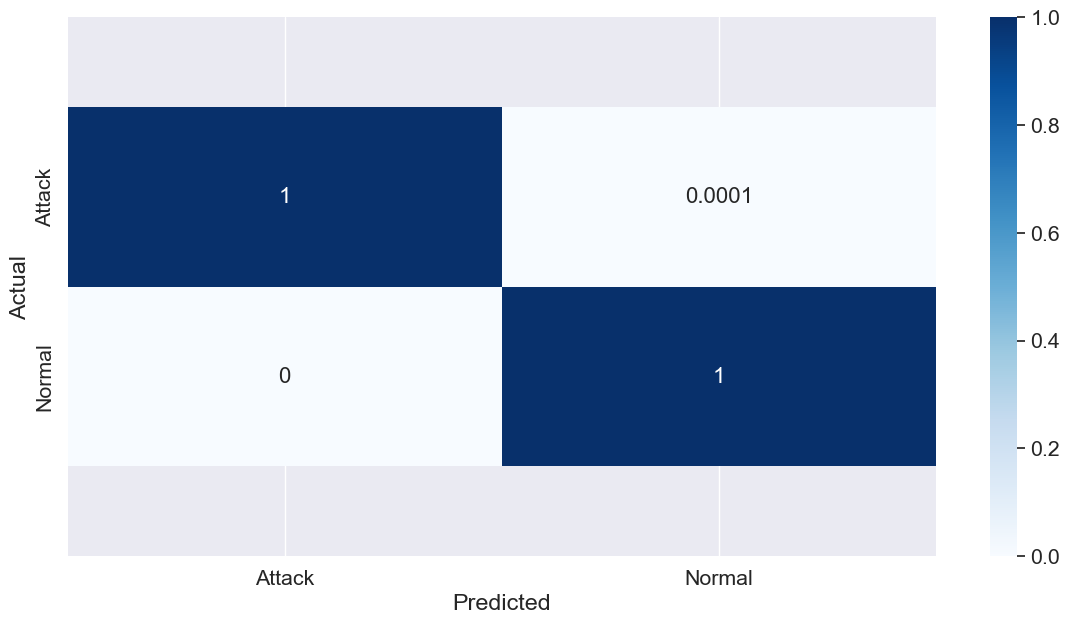

In [41]:


df_cm =  pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

### Important features

We can see the degree of contribution of each feature to the classification result by using the __feature\_importances\___ attribute of the Random Forest Classifier. We see here that, as mentioned in the paper, the 10 features extracted from our Adaptive Clustering network consistute the 10 most important features for the classifier.

In [42]:
print("Calculating feature importance scores...")
importances = model.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

Calculating feature importance scores...
Feature importance scores saved: ./results_100/rf_feature_importance_scores.pkl

15 most important features
[[22, 'count', 0.1836060180402878],
 [5, 'dst_bytes', 0.17640601152215907],
 [2, 'service', 0.10326067345056948],
 [11, 'logged_in', 0.08784401452988845],
 [31, 'dst_host_count', 0.06234012416362319],
 [36, 'dst_host_srv_diff_host_rate', 0.05597431052640082],
 [23, 'srv_count', 0.052002747083307016],
 [1, 'protocol_type', 0.04787492540004488],
 [4, 'src_bytes', 0.0453838971298812],
 [3, 'flag', 0.031779538339605264],
 [29, 'diff_srv_rate', 0.02317917426936727],
 [28, 'same_srv_rate', 0.019987100008207453],
 [34, 'dst_host_diff_srv_rate', 0.015922338667294787],
 [33, 'dst_host_same_srv_rate', 0.015826960787872227],
 [30, 'srv_diff_host_rate', 0.014939314815137078]]
Sum 15: 0.936327148733646



### Performance metrics

Finally, we compute the different performance metrics on our test set. We can see here again that this approach allows us to obtain a perfect score on every single evaluation metric, making this the new state-of-the-art approach for classification tasks.

In [43]:
print("Calculating performance metrics...")
cnf_matrix = confusion_matrix(y_actual_, y_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy = accuracy_score(y_actual_, y_hat)
precision, recall, f_score, support = prf(y_actual_, y_hat, average='weighted')
print("Accuracy : {:0.7f}, Precision : {:0.7f}, Recall : {:0.7f}, F-score : {:0.7f}, FAR: {:0.7f}"
                                                      .format(accuracy, precision,
                                                              recall, f_score, metrics_data["FAR"]))

with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler.pkl")




Calculating performance metrics...
Accuracy : 0.9999446, Precision : 0.9999446, Recall : 0.9999446, F-score : 0.9999446, FAR: 0.0000554
Performance metrics saved: ./results_100/metrics_handler.pkl


### GRAPHES



losses: [21.542582416534422, 21.488652646541595, 21.414564323425292, 21.388910508155824, 21.399909734725952, 21.347198879718782, 21.294095242023467, 21.280581891536713, 21.256675553321838, 21.206387174129485, 21.187036979198457, 21.146516835689546, 21.11959183216095, 21.08702152967453, 21.08541969060898, 21.042720520496367, 21.009117865562438, 20.964017033576965, 20.959763157367707, 20.934660732746124, 20.920138442516325, 20.878734016418456, 20.849750816822052, 20.814537262916566, 20.78992862701416, 20.78252750635147, 20.749133241176605, 20.717303586006164, 20.69498907327652, 20.67137975692749, 20.649958324432372, 20.62473520040512, 20.6131543636322, 20.551404690742494, 20.53779798746109, 20.514793872833252, 20.497255754470824, 20.446065735816955, 20.430215084552763, 20.398354387283327, 20.377049922943115, 20.34656630754471, 20.32069730758667, 20.28915419578552, 20.25176908969879, 20.23948904275894, 20.223436379432677, 20.184696984291076, 20.169125545024873, 20.138886618614197, 20.1131

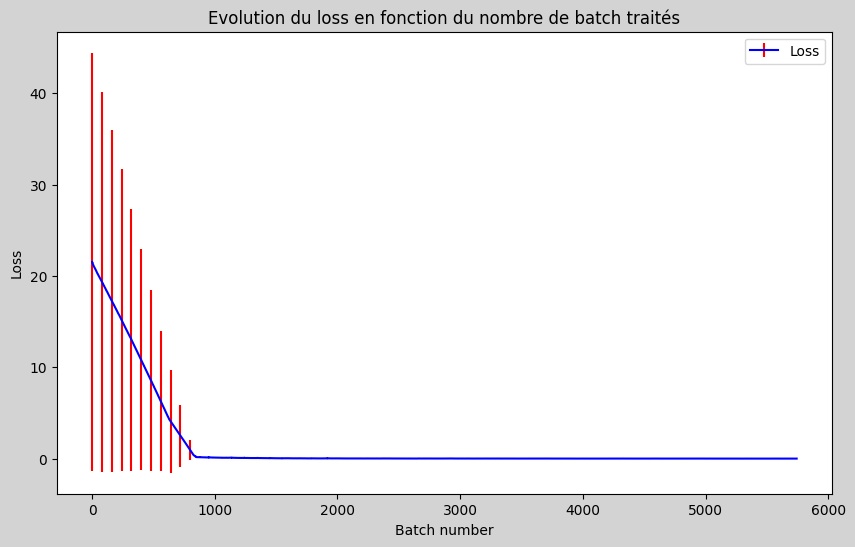

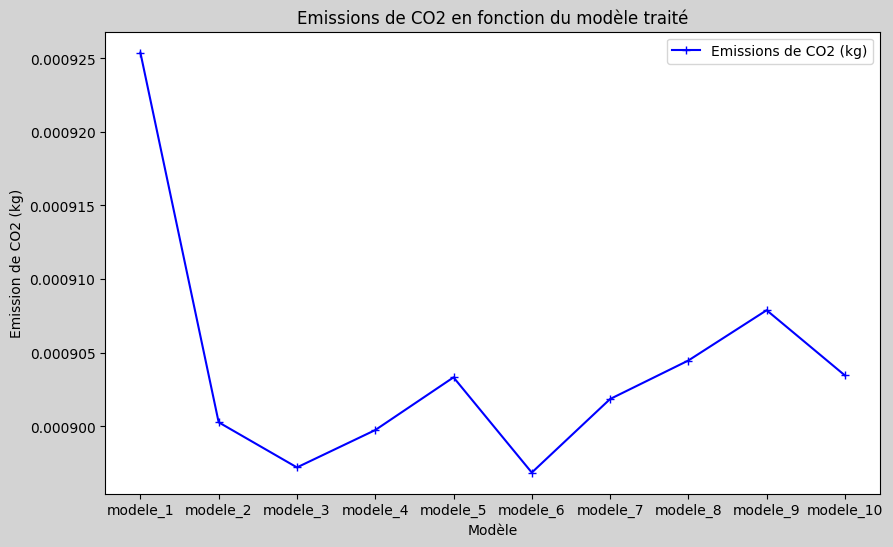

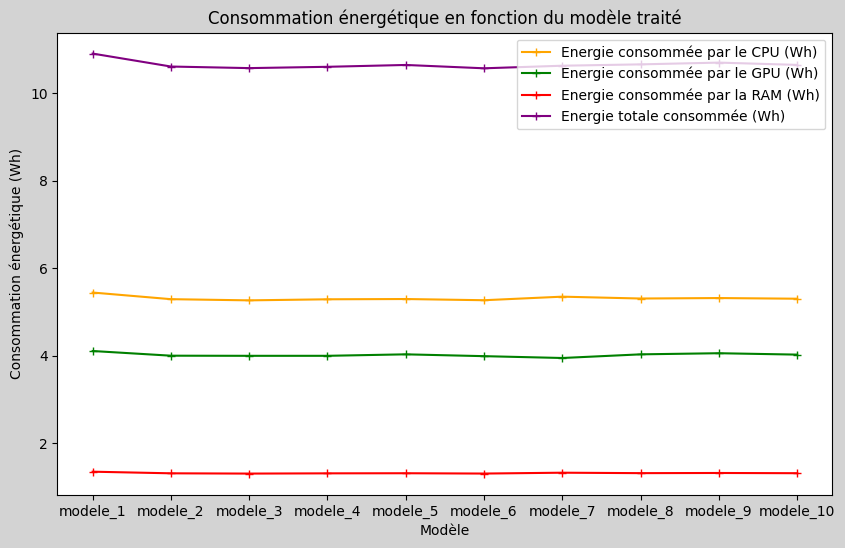

In [10]:
couleurs = ['blue','orange','green','red']

import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st
import statistics as stat
import os
import sys

def confidence_interval(data,confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    se = st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2.,n-1)
    return h



with open(results_path+"jeu_de_donnees/dic_loss.pkl", 'rb') as file:
    dic_loss = pkl.load(file)


x = range(len(dic_loss["entrainement_1"]['epoch_0'])*4)

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

#init losses
losses = {j: [0 for i in range(len(dic_loss["entrainement_1"]["epoch_0"]))] for j in dic_loss["entrainement_1"].keys()}


#Calcul de la somme des losses pour chaque tentative et à chaque epoch
for tentative in dic_loss.keys():
    # print(tentative)
    for epoch in dic_loss[tentative].keys():
        # print(epoch)
        for v_loss in range(len(losses[epoch])):
            # print(f"loss courant: {losses[epoch][v_loss]} / somme: {dic_loss[tentative][epoch][v_loss]}")
            losses[epoch][v_loss] += dic_loss[tentative][epoch][v_loss]

#Mise à jour du dico loss
# losses = {j: [i/len(dic_loss.keys()) for i in losses[j]] for j in dic_loss["entrainement_1"].keys()}
losses = {"valeurs" : losses["epoch_0"] + losses["epoch_1"] + losses["epoch_2"] + losses["epoch_3"]}
losses = [i/len(dic_loss.keys()) for i in losses["valeurs"]]

with open(results_path+"jeu_de_donnees/moyenne_loss.pkl", 'wb') as fichier:
    pkl.dump(losses,fichier)

print("losses:",losses)

#Préparation des barres d'erreurs
# print("std_loss")
std_loss = []
transfert = {i : dic_loss[i]["epoch_0"]+dic_loss[i]["epoch_1"]+dic_loss[i]["epoch_2"]+dic_loss[i]["epoch_3"] for i in dic_loss.keys()}

for i in range(len(transfert["entrainement_1"])):
    data = [transfert[j][i] for j in transfert.keys()]
    std_loss.append(confidence_interval(data))


plt.errorbar(x, losses, yerr=[std_loss[i] if (i%80==0) else 0 for i in range(len(losses))],label="Loss",color=couleurs[0], ecolor='red')
             
                 
#Graphe général
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités')
plt.legend()
plt.savefig(results_path + './courbes/loss_evolution_with_uncertainty_4epochs.png')  # Sauvegarder la figure



# with open(results_path+"jeu_de_donnees/"+"moyenne_loss.pkl", 'wb') as file:
#         pkl.dump(losses, file)
with open(results_path+"jeu_de_donnees/"+"std_loss.pkl", 'wb') as file:
        pkl.dump(std_loss, file)


#Partie émissions
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
liste_x = []
liste_emissions_y = []
liste_cpu_energy_y = []
liste_gpu_energy_y = []
liste_ram_energy_y = []
liste_total_energy_y = []

with open(results_path+"emissions.csv", "r") as csvfile:
    lecteur = csv.DictReader(csvfile, delimiter=',')
    for ligne in lecteur:
        print(ligne)
        if ligne['project_name'] != "initialisation":
            liste_emissions_y.append(float(ligne["emissions"]))
            liste_cpu_energy_y.append(float(ligne["cpu_energy"])*1000)
            liste_gpu_energy_y.append(float(ligne["gpu_energy"])*1000)
            liste_ram_energy_y.append(float(ligne["ram_energy"])*1000)
            liste_total_energy_y.append(float(ligne["energy_consumed"])*1000)
            liste_x.append(ligne['project_name'])



plt.plot(liste_x,liste_emissions_y,label="Emissions de CO2 (kg)",color="blue",marker='+')
plt.xlabel('Modèle')
plt.ylabel('Emission de CO2 (kg)')
plt.title('Emissions de CO2 en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/emission_Co2.png')

#partie consommation
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

plt.plot(liste_x,liste_cpu_energy_y,label="Energie consommée par le CPU (Wh)",color="orange",marker='+')
plt.plot(liste_x,liste_gpu_energy_y,label="Energie consommée par le GPU (Wh)",color="green",marker='+')
plt.plot(liste_x,liste_ram_energy_y,label="Energie consommée par la RAM (Wh)",color="red",marker='+')
plt.plot(liste_x,liste_total_energy_y,label="Energie totale consommée (Wh)",color="purple",marker='+')

plt.xlabel('Modèle')
plt.ylabel('Consommation énergétique (Wh)')
plt.title('Consommation énergétique en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/conso_electrique.png')

plt.show()

#Conservation des données
dico_enviro = {}
dico_enviro["emissions"] = liste_emissions_y
dico_enviro["cpu_energy"] = liste_cpu_energy_y
dico_enviro["gpu_energy"] = liste_gpu_energy_y
dico_enviro["ram_energy"] = liste_ram_energy_y
dico_enviro["total_energy"] = liste_total_energy_y
dico_enviro["liste_x"] = liste_x

with open(results_path+"jeu_de_donnees/"+"dico_enviro.pkl", 'wb') as file:
        pkl.dump(dico_enviro, file)

#probleme: toutes les mesures de emissions.csv sont nommées "code carbon"